# Modeling 
---

## Load in our data for modeling and any necessary imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     cross_val_predict, StratifiedKFold, GridSearchCV, KFold)
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from nltk.stem.porter import *
from nltk.stem import PorterStemmer

plt.style.use('fivethirtyeight')

np.random.seed(72)

In [2]:
model_reviews = pd.read_csv('../data/final_reviews_modeling.csv')

print(model_reviews.shape)
model_reviews.head()

(79768, 116)


,num_players,critic_score,avg_user_score,user_score,target,console_ps4,console_ps5,console_switch,console_xbox-series-x,console_xboxone,...,souls,story,thing,things,think,time,times,want,way,world
0,30,97,8.3,6,0,1,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
1,30,97,8.3,10,0,1,0,0,0,0,...,0.0,0.000000,0.0,0.417952,0.0,0.000000,0.000000,0.0,0.000000,0.0
2,30,97,8.3,7,0,1,0,0,0,0,...,0.0,0.147287,0.0,0.229875,0.0,0.170985,0.000000,0.0,0.000000,0.0
3,30,97,8.3,10,0,1,0,0,0,0,...,0.0,0.000000,0.0,0.637094,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,30,97,8.3,4,0,1,0,0,0,0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.204101,0.0,0.174666,0.0


## We will be using a Logisitic Regression and a Random Forests model for their interpretability with their coefficients. 

## Let's create a function to print out model score and cross val score along with confidence interval

In [3]:
def model_scores(cv_scores, model, X, y, model_name):  
    print(f'Score from {model_name}: {model.score(X, y):.4f}')
    print(f'Min and Max scores are: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]')
    print(f'Confidence interval is : {cv_scores.mean():.4f} \u00B1 {2*cv_scores.std():.4f}')

## Calculate baseline score

In [4]:
baseline = round(model_reviews['target'].value_counts(normalize=True)[0] * 100)
print(f'Baseline score: {baseline}%')

Baseline score: 50%


## Let's train/test split our data and then standard scale it

In [5]:
# drop target and other columns that are related to the target (above/below median average user score)
X = model_reviews.drop(['target', 'avg_user_score', 'user_score', 'critic_score'], axis=1)
y = model_reviews.target

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=72)

In [7]:
# initialize
ss = StandardScaler()

# fit on Train
X_train_ss = ss.fit_transform(X_train)

# transform test
X_test_ss = ss.transform(X_test)    

## Now let's create a Logistic Regression Model and Grid Search its best parameters

In [8]:
logreg_params = {'penalty': ['l1', 'l2', 'elasticnet'], 
                 'solver': ['liblinear', 'saga', 'newton-cg'],
                 'C': [0.001, 0.01, 0.1, 1, 10]
                }

logreg_gridsearch = GridSearchCV(LogisticRegression(max_iter=1000, random_state=72), 
                                 logreg_params, 
                                 cv=5, 
                                 n_jobs=-1, 
                                 verbose=1)

logreg_gridsearch.fit(X_train_ss, y_train)
logreg_gridsearch.best_params_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


C:\Users\Cisco\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.82209239 0.82220208        nan 0.85772722 0.85772722 0.85775856
        nan        nan        nan 0.86267912 0.8629612         nan
 0.86434018 0.86441854 0.86441854        nan        nan        nan
 0.86587589 0.86586022        nan 0.86601693 0.86607961 0.86606394
        nan        nan        nan 0.86647136 0.86645569        nan
 0.86647136 0.86645569 0.86645569        nan        nan        nan
 0.86640867 0.86645569        nan 0.86647136 0.86647136 0.86647136
        nan        nan        nan]
  warnings.warn(


{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

### Use the best parameters from the Grid Search in the Logistic Regression model and calculate cross val score

In [9]:
logreg = LogisticRegression(penalty='l2', 
                            solver='liblinear', 
                            C=1, 
                            max_iter=1000, random_state=72)

logreg.fit(X_train_ss, y_train)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=72)

# create a pipeline to scale our data then use it in our logistic regression model
pipeline = Pipeline([('standard_scale', ss), ('logistic_legression', logreg)])

# get the cross val scores for our data
scores = cross_val_score(pipeline, X, y, cv=cv, n_jobs=-1)

# use function to print out model and confidence interval from our cross val score
model_scores(scores, logreg, X_test_ss, y_test, 'Logistic Regression')

Score from Logistic Regression: 0.8663
Min and Max scores are: [0.8622, 0.8754]
Confidence interval is : 0.8678 ± 0.0075


### Analysis:
- Our logistic regression model produced an accuracy score of 86.63% which is 36.63% better than our baseline of 50%. 
- Our confidence interval tells us we are 95% confident that the true accuracy lies within  0.8678 ± 0.0075. Note that the interval is very small which shows the low variance in our model.
- For our logistic regression model we used 
    - Grid searched hyperparameters
    - Data standard scaled
    - Summary and user reviews cleaned and vectorized


## Extract the coefficients from our Logistic Regression

In [10]:
logreg_coefs = pd.DataFrame(list(zip(X_train.columns, np.exp(logreg.coef_[0]))), 
                           columns=['features', 'coef'])

logreg_coefs.sort_values('coef', ascending=False).head(10)

,features,coef
38,sum_mario,45.066639
9,video_game_name_in_top_40,2.211630
48,sum_rpg,1.989668
50,sum_set,1.725146
21,sum_developed,1.694664
8,rating_T,1.670524
30,sum_gameplay,1.631412
29,sum_friends,1.610289
18,sum_city,1.601844
35,sum_life,1.557891


### Analysis:
- Above we have the top 10 coefficients from our Logistic Regression model. Note coefficients have been exponentiated for easier interpretability.
- By far the best coefficient is sum_mario, which indicates that if the game summary includes “mario” i.e. a Mario game by Nintendo, the video game is 45.06 times as likely to have an average user score above 8.4 all else held equal.
- The rest of the coefficients increase likelihood of above average user score of 8.4 by 2.21 times or less.
- Interesting to note that games that specify RPG, game setting, developer, and gameplay increase likelihood of above average user score of 8.4 by 1.63+ times


## Let's create a confusion matrix to see how our model did at predicting the target variable

In [11]:
# create pipeline and use cross_val_predict to get predictions
pipeline = Pipeline([('standard_scale', ss), ('logistic_legression', logreg)])
predicted_cross = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)

# create confusion matrix from predictions
con_matrix = confusion_matrix(y, predicted_cross, labels=[1, 0])

,predicted at/above,predicted below
at/above med average_user_score,34563,5321
below med average_user_score,5225,34659


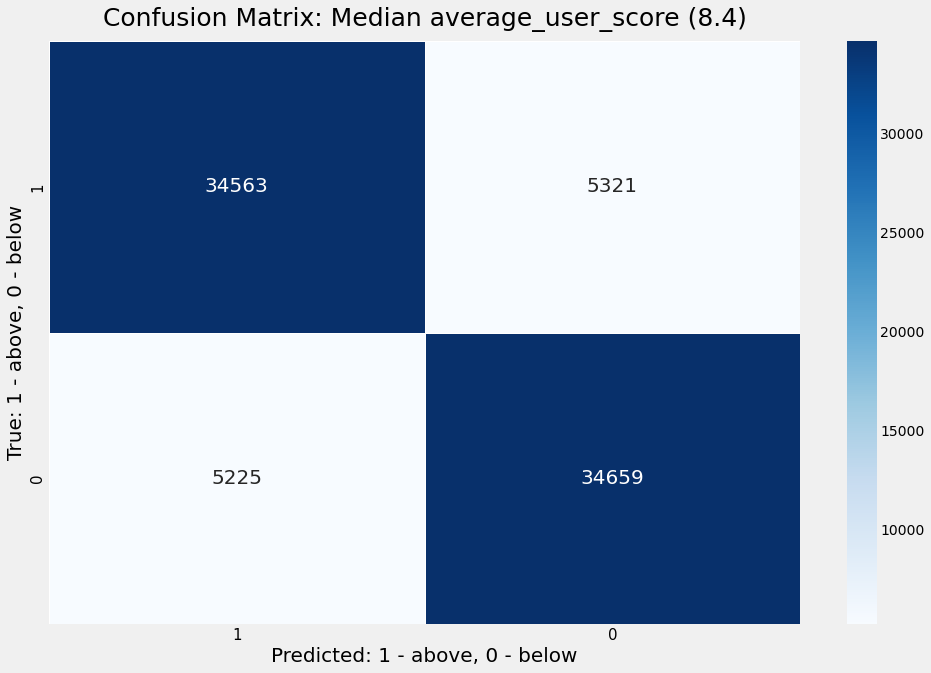

In [12]:
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(con_matrix, annot=True, fmt='g', linewidths=1,\
            linecolor='white', xticklabels=[1, 0], yticklabels=[1,0], cmap='Blues', annot_kws={"size": 20})

plt.title('Confusion Matrix: Median average_user_score (8.4)', fontsize=25, pad=15)
plt.xlabel('Predicted: 1 - above, 0 - below', fontsize=20);
plt.ylabel('True: 1 - above, 0 - below', fontsize=20);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

pd.DataFrame(con_matrix, 
             index=['at/above med average_user_score', 'below med average_user_score'], 
             columns=['predicted at/above', 'predicted below'])

In [13]:
print('CLassification report for classifier\n %s' % (classification_report(y, predicted_cross, labels=[1, 0])))

CLassification report for classifier
               precision    recall  f1-score   support

           1       0.87      0.87      0.87     39884
           0       0.87      0.87      0.87     39884

    accuracy                           0.87     79768
   macro avg       0.87      0.87      0.87     79768
weighted avg       0.87      0.87      0.87     79768



### Analysis:
- From the confusion matrix and the classification report we can see that our logistic regression model has an accuracy score of 87%
- We also have a precision score of 87% for both targets of 1 and 0, which means that when our model predicts if a game is above the median average user score (or below) (8.4) it is correct 87% of the time
- Our recall score is 87% for both targets of 1 and 0, which means that it correctly identifies 87% of games above the median average user score (or below)


## Now let's create a Random Forests Model and Grid Search its best parameters

In [14]:
rf_params = {'n_estimators': range(180, 210, 10), 
             'max_depth': range(32, 35, 1), 
             'class_weight': ['balanced', 'balanced_subsample']}

rf_gridsearch = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=72), 
                             rf_params,
                             cv=5, 
                             n_jobs=-1,
                             verbose=1)

rf_gridsearch.fit(X_train_ss, y_train)
rf_gridsearch.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'class_weight': 'balanced', 'max_depth': 33, 'n_estimators': 190}

### Use the best parameters from the Grid Search in the Random Forests model

In [15]:
%%time
rf = RandomForestClassifier(n_jobs=-1, random_state=72, 
                            n_estimators=190, 
                            class_weight='balanced', 
                            max_depth=33)

rf.fit(X_train_ss, y_train)

cv = KFold(n_splits=10, random_state=72, shuffle=True)

# create a pipeline to scale our data then use it in our logistic regression model
pipeline = Pipeline([('standard_scale', ss), ('random_forests', rf)])

# get the cross val scores for our data
scores = cross_val_score(pipeline, X, y, cv=cv, n_jobs=-1)

# use function to print out model and confidence interval from our cross val score
model_scores(scores, rf, X_test_ss, y_test, 'Random Forest')

Score from Random Forest: 1.0000
Min and Max scores are: [0.9999, 1.0000]
Confidence interval is : 0.9999 ± 0.0001
Wall time: 31.4 s


### Analysis:
- Our random forests model produced an accuracy score of 100%, 50% better than our baseline
    - Train and test sets were double-checked to verify that no data leakage was present
- We have a confidence interval of 99.99% ± 0.01%
    - The confidence interval is extremely narrow which shows we have low variance in our model.
- This accuracy score was a byproduct of the grid searched hyperparameters
    - Data was also standard scaled
    - Summary and user reviews cleaned and vectorizes



## Let's look at the top 10 `feature_importances_` from our Random Forest model

In [16]:
df_feature_importance = pd.DataFrame({'feature':X_train.columns,
                                      'importance':rf.feature_importances_})
df_feature_importance.sort_values('importance', ascending=False).head(10)

,feature,importance
0,num_players,0.045441
41,sum_number,0.044135
61,sum_world,0.033214
40,sum_new,0.029794
9,video_game_name_in_top_40,0.029644
55,sum_time,0.027162
3,console_switch,0.026152
23,sum_enemies,0.024848
5,console_xboxone,0.023175
1,console_ps4,0.021713


In [17]:
model_reviews.groupby('target').describe()['num_players']

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,39884.0,12.708730,25.450791,1.0,1.0,3.0,12.0,150.0
1,39884.0,6.826823,18.245982,1.0,1.0,1.0,3.0,150.0


### Analysis:
- The above features are the top 10 features that our model claims have the best predictive power/most important.
- num_players is the only continuous feature 
    - Looking into the feature and its relationship to the target we can see that for games above the median average user score (8.4) the average is around 7
    - The average for below the median is around 12
    - We can also see that the number of players for the majority of those above the target is less than 3. Most likely indicative of single-player games.
- The rest of the features are categorical or engineered features
    - We see a few keywords that appear in the summary like “number”, “world”, “new”, “time”, and “enemies”. 


## Let's see the confusion matrix

In [18]:
# create pipeline and use cross_val_predict to get predictions
pipeline = Pipeline([('standard_scale', ss), ('random_forests', rf)])
predicted_cross = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)

# create confusion matrix from predictions
con_matrix = confusion_matrix(y, predicted_cross, labels=[1, 0])

,predicted at/above,predicted below
at/above med average_user_score,39879,5
below med average_user_score,0,39884


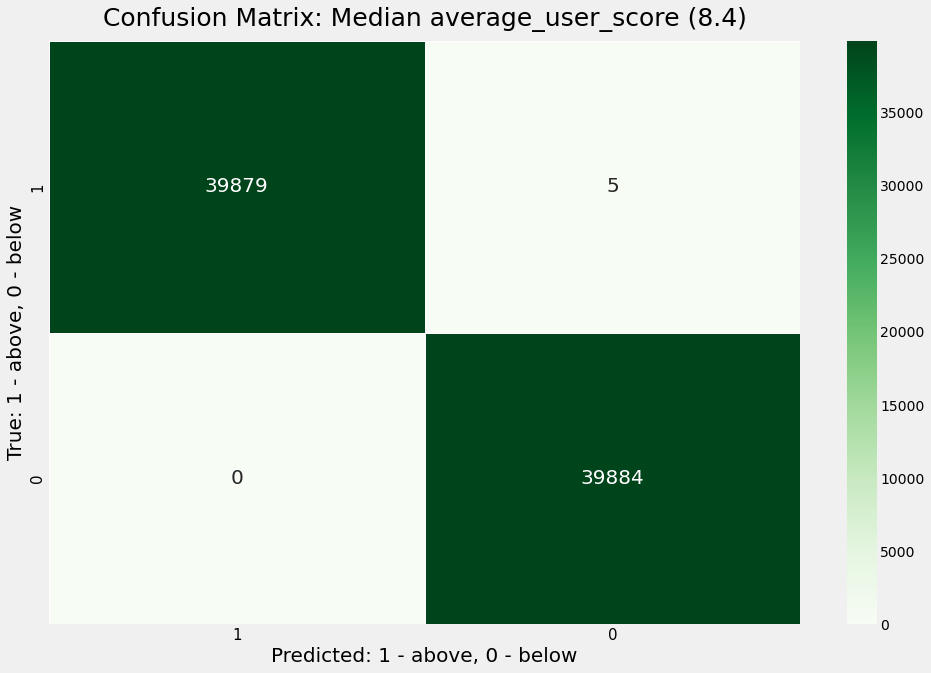

In [19]:
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(con_matrix, annot=True, fmt='g', linewidths=1,\
            linecolor='white', xticklabels=[1, 0], yticklabels=[1,0], cmap='Greens', annot_kws={"size": 20})

plt.title('Confusion Matrix: Median average_user_score (8.4)', fontsize=25, pad=15)
plt.xlabel('Predicted: 1 - above, 0 - below', fontsize=20);
plt.ylabel('True: 1 - above, 0 - below', fontsize=20);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

pd.DataFrame(con_matrix, 
             index=['at/above med average_user_score', 'below med average_user_score'], 
             columns=['predicted at/above', 'predicted below'])

In [20]:
print('CLassification report for classifier\n %s' % (classification_report(y, predicted_cross, labels=[1, 0])))

CLassification report for classifier
               precision    recall  f1-score   support

           1       1.00      1.00      1.00     39884
           0       1.00      1.00      1.00     39884

    accuracy                           1.00     79768
   macro avg       1.00      1.00      1.00     79768
weighted avg       1.00      1.00      1.00     79768



### Analysis:
- From the confusion matrix and the classification report we can see that our random forest model has an accuracy score of 100%
- We also have a precision score of 100% for both targets of 1 and 0, which means that when our model predicts if a game is above the median average user score (or below) (8.4) it is correct 100% of the time
- Our recall score is 100% for both targets of 1 and 0, which means that it correctly identifies 100% of games above the median average user score (or below)


### Our random forest model produced the best accuracy score. However, due to the better interpretability of our logistic regression model's coefficients, we will be focusing our efforts on improving its score by lemmatizing the text in our dataset. If we wanted to use a model in production solely to predict whether or not a game would be above the median average user score, we would use the random forests model. Our main goal is to identify the main attributes that will help a game score higher than our median average user score.

## Let's lemmatize our `user_reviews` and summary

In [21]:
lem = pd.read_csv('../data/df_for_further_nlp.csv')
nlp = spacy.load('en_core_web_sm')

In [22]:
%%time
lem['lemmatized_user_review'] = [ ' '.join([word.lemma_ for word in nlp(review)]) for review in lem.user_review]

Wall time: 20min 52s


In [23]:
lem.head(2)

,summary,num_players,critic_score,avg_user_score,user_review,user_score,target,console_ps4,console_ps5,console_switch,console_xbox-series-x,console_xboxone,rating_E10+,rating_M,rating_T,video_game_name_in_top_40,developer_in_top_25,genre_in_top_20,lemmatized_user_review
0,developed by the creators of grand theft auto ...,32,97,8.6,this site is a joke this the first time when i...,9,1,1,0,0,0,0,0,1,0,1,1,1,this site be a joke this the first time when I...
1,developed by the creators of grand theft auto ...,32,97,8.6,fair review of rdr2 im almost <number> finishe...,7,1,1,0,0,0,0,0,1,0,1,1,1,fair review of rdr2 I m almost < number > fini...


### Now convert our lemmatized_user_review data into matrix representation using TfidfVectorizer and save to a dataframe.

In [24]:
# add several words that we want to ommit to stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(['game', 'games', 'make', 
                                               'makes', 'im', 'ive', 'que', 'el', 
                                               'en', 'es', 'number', 'like', 'just', 'la', 'juego'])

tvec = TfidfVectorizer(stop_words=my_stop_words, 
                       strip_accents='ascii',
                       lowercase=True,
                       max_features=50, 
                       norm='l2', 
                       max_df=0.9,
                       smooth_idf=True)

tvec.fit(lem['lemmatized_user_review'])

TfidfVectorizer(max_df=0.9, max_features=50,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents='ascii')

In [25]:
df_lem_user_review_tvec = pd.DataFrame(tvec.transform(lem['lemmatized_user_review']).todense(), 
                                       columns=tvec.get_feature_names())
df_lem_user_review_tvec.head(2)

,amazing,bad,bit,boss,buy,character,combat,come,design,different,...,thing,think,time,try,use,ve,want,way,world,year
0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.00000,0.000000,0.404759,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.539939
1,0.0,0.0,0.177804,0.0,0.084342,0.068117,0.0,0.081254,0.0,0.0,...,0.14958,0.077283,0.242388,0.087613,0.084401,0.0,0.235402,0.37283,0.143866,0.000000


## Now lemmatize  `summary`

In [26]:
%%time
lem['lemmatized_summary'] = [ ' '.join([word.lemma_ for word in nlp(summ)]) for summ in lem.summary]

Wall time: 23min 4s


In [27]:
lem.head(2)

,summary,num_players,critic_score,avg_user_score,user_review,user_score,target,console_ps4,console_ps5,console_switch,console_xbox-series-x,console_xboxone,rating_E10+,rating_M,rating_T,video_game_name_in_top_40,developer_in_top_25,genre_in_top_20,lemmatized_user_review,lemmatized_summary
0,developed by the creators of grand theft auto ...,32,97,8.6,this site is a joke this the first time when i...,9,1,1,0,0,0,0,0,1,0,1,1,1,this site be a joke this the first time when I...,develop by the creator of grand theft auto v a...
1,developed by the creators of grand theft auto ...,32,97,8.6,fair review of rdr2 im almost <number> finishe...,7,1,1,0,0,0,0,0,1,0,1,1,1,fair review of rdr2 I m almost < number > fini...,develop by the creator of grand theft auto v a...


### Now convert our lemmatized_summary data into matrix representation using TfidfVectorizer and save to a dataframe.

In [28]:
# add several words that we want to ommit to stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(['game', 'games', 'make', 
                                               'makes', 'im', 'ive', 'que', 'el', 
                                               'en', 'es', 'like', 'just', 'la', 'juego'])

tvec_2 = TfidfVectorizer(stop_words=my_stop_words, 
                       strip_accents='ascii',
                       lowercase=True,
                       max_features=50, 
                       norm='l2', 
                       max_df=0.9,
                       smooth_idf=True)

tvec_2.fit(lem['lemmatized_summary'])

TfidfVectorizer(max_df=0.9, max_features=50,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents='ascii')

In [29]:
df_lem_summary_tvec = pd.DataFrame(tvec_2.transform(lem['lemmatized_summary']).todense(), 
                                       columns=tvec_2.get_feature_names())
df_lem_summary_tvec.head(2)

,ability,action,adventure,attack,battle,bring,character,choice,city,combat,...,team,time,unique,use,war,way,weapon,wild,world,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316326,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.226367,0.0,0.329001,0.159589,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316326,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.226367,0.0,0.329001,0.159589,0.0


## Convert both tvec df into one

In [30]:
# change the name of summary tvec df to be able to join
df_lem_summary_tvec.columns = ['sum_' + col for col in df_lem_summary_tvec.columns]

In [31]:
combined_df = df_lem_summary_tvec.join(df_lem_user_review_tvec)
combined_df.head()

,sum_ability,sum_action,sum_adventure,sum_attack,sum_battle,sum_bring,sum_character,sum_choice,sum_city,sum_combat,...,thing,think,time,try,use,ve,want,way,world,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316326,0.0,0.0,...,0.000000,0.000000,0.404759,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.539939
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316326,0.0,0.0,...,0.149580,0.077283,0.242388,0.087613,0.084401,0.000000,0.235402,0.37283,0.143866,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316326,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.472103,0.00000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316326,0.0,0.0,...,0.000000,0.000000,0.296090,0.000000,0.000000,0.366567,0.000000,0.00000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316326,0.0,0.0,...,0.294842,0.000000,0.238889,0.000000,0.000000,0.000000,0.309338,0.00000,0.000000,0.000000


### Merge this combined with our lem df and drop `summary` and `user_review`

In [32]:
lem_df_model = lem.drop(columns=['summary', 'user_review', 'lemmatized_user_review', 'lemmatized_summary'])\
.join(combined_df)

In [33]:
lem_df_model.head()

,num_players,critic_score,avg_user_score,user_score,target,console_ps4,console_ps5,console_switch,console_xbox-series-x,console_xboxone,...,thing,think,time,try,use,ve,want,way,world,year
0,32,97,8.6,9,1,1,0,0,0,0,...,0.000000,0.000000,0.404759,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.539939
1,32,97,8.6,7,1,1,0,0,0,0,...,0.149580,0.077283,0.242388,0.087613,0.084401,0.000000,0.235402,0.37283,0.143866,0.000000
2,32,97,8.6,6,1,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.472103,0.00000,0.000000,0.000000
3,32,97,8.6,7,1,1,0,0,0,0,...,0.000000,0.000000,0.296090,0.000000,0.000000,0.366567,0.000000,0.00000,0.000000,0.000000
4,32,97,8.6,7,1,1,0,0,0,0,...,0.294842,0.000000,0.238889,0.000000,0.000000,0.000000,0.309338,0.00000,0.000000,0.000000


## Take a look at the target variable

In [34]:
lem_df_model.target.value_counts()

1    54451
0    39884
Name: target, dtype: int64

### Our targets are a bit imbalanced, with over 10k more 1s than 0s (above/below median avg_user_score). To combat this we are going to down sample rows with target of 1 to get a balanced target.

In [35]:
# randomly sample the same number of rows above target to get equal number of rows with below target 
random_target_1s = lem_df_model[lem_df_model.target == 1].sample(n=39884, replace=True)

# drop rows where target = 1
lem_df_model.drop(lem_df_model[lem_df_model.target == 1].index, inplace=True)

# merge df with random rows w/ target = 1
final_lem_df_model = pd.concat([lem_df_model, random_target_1s], ignore_index=True)

final_lem_df_model.head()

,num_players,critic_score,avg_user_score,user_score,target,console_ps4,console_ps5,console_switch,console_xbox-series-x,console_xboxone,...,thing,think,time,try,use,ve,want,way,world,year
0,30,97,8.3,6,0,1,0,0,0,0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1,30,97,8.3,10,0,1,0,0,0,0,...,0.366638,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2,30,97,8.3,7,0,1,0,0,0,0,...,0.185781,0.191973,0.150525,0.0,0.0,0.186353,0.194915,0.000000,0.0,0.200796
3,30,97,8.3,10,0,1,0,0,0,0,...,0.598522,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4,30,97,8.3,4,0,1,0,0,0,0,...,0.000000,0.000000,0.142292,0.0,0.0,0.000000,0.000000,0.175094,0.0,0.189814


## Let's train/test split our data and then standard scale it

In [36]:
# drop target and other columns that are related to the target (above/below median average user score)
X = final_lem_df_model.drop(['target', 'avg_user_score', 'user_score', 'critic_score'], axis=1)
y = final_lem_df_model.target

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=72)

In [38]:
# initialize
ss = StandardScaler()

# fit on Train
X_train_ss = ss.fit_transform(X_train)

# transform test
X_test_ss = ss.transform(X_test)    

## Now let's create a Logistic Regression Model and Grid Search its best parameters

In [39]:
logreg_params = {'penalty': ['l1', 'l2', 'elasticnet'], 
                 'solver': ['liblinear', 'saga', 'newton-cg'],
                 'C': [1, 10, 100]
                }

logreg_gridsearch = GridSearchCV(LogisticRegression(max_iter=1000, random_state=72), 
                                 logreg_params, 
                                 cv=5, 
                                 n_jobs=-1, 
                                 verbose=1)

logreg_gridsearch.fit(X_train_ss, y_train)
logreg_gridsearch.best_params_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\Cisco\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.87040468 0.87038901        nan 0.87021664 0.87021664 0.87021664
        nan        nan        nan 0.87042035 0.87045169        nan
 0.87045169 0.87042035 0.87042035        nan        nan        nan
 0.87042035 0.87045169        nan 0.87045169 0.87045169 0.87042035
        nan        nan        nan]
  warnings.warn(


{'C': 10, 'penalty': 'l1', 'solver': 'saga'}

### Use the best parameters from the Grid Search in the Logistic Regression model and calculate cross val score

In [40]:
logreg = LogisticRegression(penalty='l1', 
                            solver='saga', 
                            C=10, 
                            max_iter=1000, random_state=72)

logreg.fit(X_train_ss, y_train)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=72)

# create a pipeline to scale our data then use it in our logistic regression model
pipeline = Pipeline([('standard_scale', ss), ('logistic_legression', logreg)])

# get the cross val scores for our data
scores = cross_val_score(pipeline, X, y, cv=cv, n_jobs=-1)

# use function to print out model and confidence interval from our cross val score
model_scores(scores, logreg, X_test_ss, y_test, 'Logistic Regression')

Score from Logistic Regression: 0.8711
Min and Max scores are: [0.8623, 0.8802]
Confidence interval is : 0.8719 ± 0.0112


### Analysis:
- Our logistic regression model with lemmatized text produced an accuracy score of 87.11% which is 37.11% better than our baseline of 50%. This is also 0.48% better than our logistic regression model with regular text.
- Our confidence interval tells us we are 95% confident that the true accuracy lies within  0.8719 ± 0.0112. Note that the interval is very small which shows the low variance in our model.
    - Mean cross val score increased by 0.41% but interval widened by 0.37% when compared to the non lemmatized model
- For our logistic regression model we used 
    - Grid searched hyperparameters
    - Data standard scaled
    - Summary and user reviews cleaned and vectorized
    - Text lemmatized

## Extract the coefficients from our Logistic Regression

In [41]:
logreg_coefs = pd.DataFrame(list(zip(X_train.columns, np.exp(logreg.coef_[0]))), 
                           columns=['features', 'coef'])

logreg_coefs.sort_values('coef', ascending=False).head(10)

,features,coef
59,sum_wild,2.546174
40,sum_life,2.296688
20,sum_city,1.830125
21,sum_combat,1.715056
47,sum_return,1.663090
43,sum_number,1.538664
57,sum_way,1.509068
11,genre_in_top_20,1.483531
9,video_game_name_in_top_40,1.470215
56,sum_war,1.460263


### Analysis:
- Above we have the top 10 coefficients from our Logistic Regression model with lemmatized text. Note coefficients have been exponentiated for easier interpretability.
- The top 2 coefficients are sum_wild and sum_life, which are words that appear in the summary of a video game. According to these coefficients, having these in the summary increases the likelihood of above an average user score by 2.54 and 2.29 times.
	- wild might refer to Breath of the Wild, a critically acclaimed game, and life might just mean games that emphasize the living breathing worlds created, further investigation advised.
- The rest of the coefficients increase the likelihood of above average user score of 8.4 by 1.83 times or less.
- Interesting to note that games in our top 40 list decreased in likelihood from our model with regular text to our lemmatized text model. From increasing likelihood by 2.21 times to 1.47 times.
- Also interesting to note that when we lemmatized the text the word mario does not show up in our coefficients here. In the previous non lemmatized model it was by far the best predictor.


## Let's create a confusion matrix to see how our model did at predicting the target variable

In [42]:
# create pipeline and use cross_val_predict to get predictions
pipeline = Pipeline([('standard_scale', ss), ('logistic_legression', logreg)])
predicted_cross = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)

# create confusion matrix from predictions
con_matrix = confusion_matrix(y, predicted_cross, labels=[1, 0])

,predicted at/above,predicted below
at/above med average_user_score,34614,5270
below med average_user_score,4947,34937


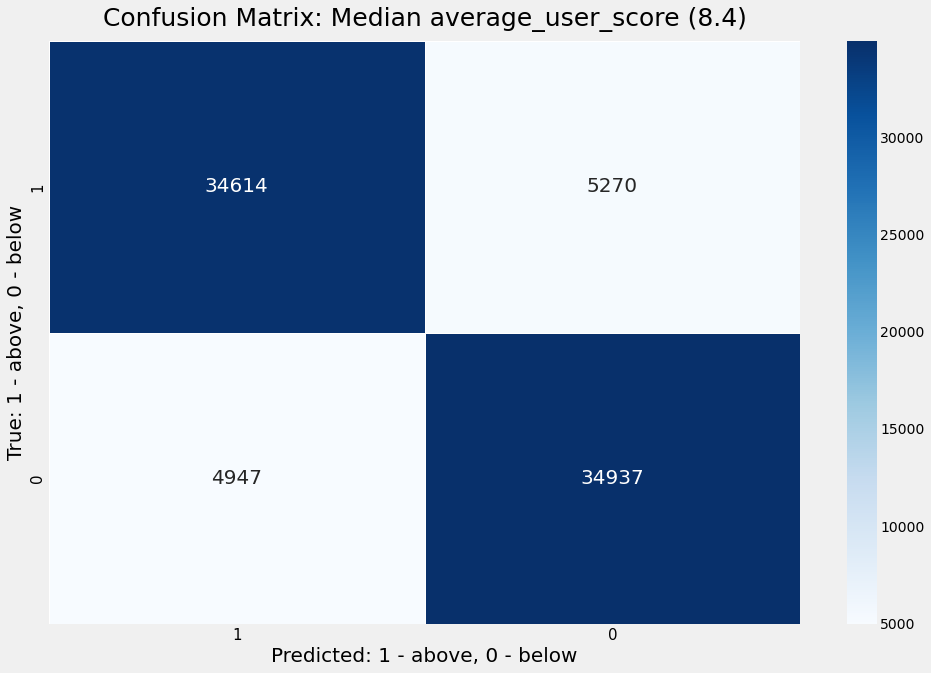

In [43]:
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(con_matrix, annot=True, fmt='g', linewidths=1,\
            linecolor='white', xticklabels=[1, 0], yticklabels=[1,0], cmap='Blues', annot_kws={"size": 20})

plt.title('Confusion Matrix: Median average_user_score (8.4)', fontsize=25, pad=15)
plt.xlabel('Predicted: 1 - above, 0 - below', fontsize=20);
plt.ylabel('True: 1 - above, 0 - below', fontsize=20);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

pd.DataFrame(con_matrix, 
             index=['at/above med average_user_score', 'below med average_user_score'], 
             columns=['predicted at/above', 'predicted below'])

In [44]:
print('CLassification report for classifier\n %s' % (classification_report(y, predicted_cross, labels=[1, 0])))

CLassification report for classifier
               precision    recall  f1-score   support

           1       0.87      0.87      0.87     39884
           0       0.87      0.88      0.87     39884

    accuracy                           0.87     79768
   macro avg       0.87      0.87      0.87     79768
weighted avg       0.87      0.87      0.87     79768



### Analysis:
- From the confusion matrix and the classification report we can see that our logistic regression model has an accuracy score of 87%
- We also have a precision score of 87% for targets of 1 and 87% for targets of 0, which means that when our model predicts if a game is above the median average user score (8.4) it is correct 87% of the time. When it predicts if below it is correct 87% of the time.
- Our recall score is 87% for targets of 1 and 88% for targets of 0, which means that it correctly identifies 87% of games above the median average user score and correctly identifies 88% of games below.


## Conclusions & Recommendations
We set out to create a model that could identify the key attributes that would help a video game achieve a higher average user score. Our best model was a random forest model but due to its lack of interpretability with its coefficients, emphasis was placed on the logistic regression model. With lemmatized text, our model produced an accuracy score of 87.11% which is 37.11% better than our baseline of 50%. Our model also had coefficients and with these coefficients we identified the top 10 attributes that correlate to better chances of a video game achieving a higher average user score.

Below are the top 10 coefficients from our logistic regression model. Note that coefficients have been exponentiated for easier interpretability.
- Sum_wild
- Sum_life
- Sum_city
- Sum_combat
- Sum_return
- Sum_number
- Sum_way
- Genre_in_top_20
- Video_game_name_in_top_40
- Sum_war

8 out of the 10 coefficients have to do with the certain words used in a game summary. The words wild and life had the highest coefficients from our model, they increased likelihood of having an above average user score by 2.54 and 2.29 times respectively. The other words used in summary increased likelihood from 1.83 times to 1.46 times going from the top down of the above list. Words that describe and emphasize a video game with vibrant life, wild settings, city scapes, varying combat, and war like scenarios had a positive increase in a game having a higher average user score. The tokenized number also showed up as increasing likelihood by 1.53 times, this can be anywhere from descriptive summaries about the vastness of the game, potential player count, or even a certain time setting or potential sequel to a previous game. 

We also see our feature engineered columns like genre in top 20 and video game name in top 40 increasing likelihood of a better average user score. These features identified wether or not a review was for a game that was one of the most popular/frequent genres/video game names. A game with a genre type in our top 20 increases likelihood of a better average user score by 1.48 times. A game thats a sequel or has some relation to game in our top 40 list increases likekilhood of a better average user score by 1.47 times. 

Our findings show key attributes for a better average user score for video games based on the list of all time video games from Metacritic. Like many things in pop culture fads come and go, one way to better improve our model is collect more data for games by certain years and see how the attributes for each year change and what stays the same. Collecting more data for both video games and user reviews is always recommended. Further steps for this project would be to streamline a process that uses a production model that can take in certain parameters for an upcoming video game and return a prediction based on the models we have made.
